In [2]:
using Distributions
using JLD2
using LinearAlgebra
using Random
using StatsFuns: logsumexp, logaddexp

include("data_structures.jl");

In [3]:
"""
Hyperparameters for the traditional HDP+,infinity generative model.

m0      : prior mean for feature vectors (d-dimensional)
k_clu   : shrinkage from cluster means mu_k toward m0
k_obj   : shrinkage from object means phi_i toward their cluster mean mu_k
k_per   : shrinkage from percepts y_io toward their object mean phi_i
a0,b0   : Inverse-Gamma hyperparameters for sigma^2 (per category)
alpha   : CRP concentration (controls number of clusters)
"""
Base.@kwdef struct TraditionalHDPHyperparams
    m0::Vector{Float64}
    k_clu::Float64
    k_obj::Float64
    a0::Float64
    b0::Float64
    alpha::Float64 = 1.0
end

"""
Sufficient statistics for a cluster (single category)
"""
Base.@kwdef mutable struct TraditionalHDPClusterStats
    n::Int                      # number of points
    sum_x::Vector{Float64}      # sum x \in R^d
    sumsq::Float64              # sum ||x||^2 (for spherical scatter) \in R
end

function TraditionalHDPClusterStats(d::Int)
    TraditionalHDPClusterStats(0, zeros(d), 0.0)
end

"""
Update stats to add or subtract an observation
"""
function add_point!(cs::TraditionalHDPClusterStats, x::Vector{Float64}; sign::Int = +1)
    @assert sign == 1 || sign == -1 "sign must be +1 or -1"
    cs.n += sign
    @. cs.sum_x += sign * x
    cs.sumsq += sign * sum(abs2, x)
    return cs
end


"""
Compute scatter S = sum ||x||^2 - n ||xbar||^2
"""
function scatter(cs::TraditionalHDPClusterStats)
    n = cs.n
    n == 0 && return 0.0
    xbar = cs.sum_x / n
    return cs.sumsq - n * sum(abs2, xbar)
end

scatter

## Posterior distributions of $\mu$ and $\sigma^2$

**Setup**

$$\mu | \sigma^2 \sim \mathcal{N}_d \big(m_0, \dfrac{1}{\kappa_{clu}} \sigma^2 \bm{I}_d \big); \;\; \sigma^2 \sim \text{Inverse-Gamma}(a_0, b_0); \;\; x_i | \mu, \sigma^2 \sim \mathcal{N}_d(\mu, \dfrac{1}{\kappa_{obj}}\sigma^2 \bm{I}_d)$$

Define sample mean $\overline{x} = \dfrac{1}{n} \sum_{i=1}^n x_i$, scatter $S = \sum_{i=1}^n ||x_i-\overline{x}||^2$

**Results**

\begin{equation}
\tag{12}
    \mu | \sigma^2, \bm{x}_{1:n} \sim \mathcal{N}_d \big(m_n, \dfrac{1}{\kappa_n} \sigma^2 \bm{I}_d \big), \sigma^2 | \bm{x}_{1:n} \sim \text{Inverse-Gamma} (a_n, b_n)
\end{equation}
where 
- $\kappa_n = \kappa_{clu} + \kappa_{obj} n$
- $m_n = \dfrac{\kappa_{clu}m_0+\kappa_{obj} n \overline{x}}{\kappa_n}$
- $a_n = a_0 + \dfrac{1}{2}nd$
- $b_n = b_0 + \dfrac{1}{2} \big[ \kappa_{obj} S + \dfrac{\kappa_{clu} \kappa_{obj} n}{\kappa_n} ||\overline{x}-m_0||^2 \big]$

In [4]:
"""
    posterior_hyperparams(cs, hyper)

Given cluster stats and prior hyperparameters, return
(kn, mn, an, bn) for that cluster.
"""
function posterior_hyperparams(cs::TraditionalHDPClusterStats, hyper::TraditionalHDPHyperparams)
    n = cs.n
    d = length(hyper.m0)
    @assert d > 0 "Dimension needs to be at least 1"
    k_clu, k_obj = hyper.k_clu, hyper.k_obj
    m0, a0, b0 = hyper.m0, hyper.a0, hyper.b0

    xbar = cs.sum_x / n
    S = scatter(cs)

    kn = k_clu + k_obj * n
    mn = (k_clu * m0 + k_obj * n * xbar) / kn
    an = a0 + 0.5 * n * d
    bn = b0 + 0.5 * (k_obj * S + k_clu * k_obj * n / kn * sum(abs2, xbar - m0))

    return kn, mn, an, bn
end

posterior_hyperparams

## Posterior predictive distribution of new observation given existing ones in the cluster

**Setup** 

Let $x_*$ denote the new observation. 

$$x_* | \mu, \sigma^2 \sim \mathcal{N}_d(\mu, \dfrac{1}{\kappa_{obj}}\sigma^2 \bm{I}_d), \mu | \sigma^2, \bm{x}_{1:n} \sim \mathcal{N}_d \big(m_n, \dfrac{1}{\kappa_n} \bm{I}_d \big), \sigma^2 | \bm{x}_{1:n} \sim \text{Inverse-Gamma} (a_n, b_n)$$

**Results**

\begin{equation}
\tag{13}
    x_* | x_{1:n} \sim \text{Multivariate-}t_{df=2a_n}\Big(m_n, \dfrac{b_n}{a_n}\big(\dfrac{1}{\kappa_{obj}} + \dfrac{1}{\kappa_n}\big)\bm{I}_d \Big)
\end{equation}


In [5]:
"""
    log_predictive_existing(x, cs, hyper)

Compute log p(x | cluster with stats `cs`) using the multivariate t predictive
(eq. 13).
"""
function log_predictive_existing(x::Vector{Float64},
                                 cs::TraditionalHDPClusterStats,
                                 hyper::TraditionalHDPHyperparams)
    @assert cs.n > 0 "Need to have at least one observation in the cluster"
    d = length(x)
    kn, mn, an, bn = posterior_hyperparams(cs, hyper)
    df = 2 * an
    Sigma = (bn / an) * (1 / hyper.k_obj + 1 / kn) * Matrix(1.0I, d, d)
    dist = MvTDist(df, mn, Sigma)
    return logpdf(dist, x)
end

log_predictive_existing

## Predictive distribution of new observation given new cluster

\begin{equation}
\tag{14}
    x_* | \text{new cluster} \sim \text{Multivariate-}t_{df=2a_0}\Big(m_0, \dfrac{b_0}{a_0}\big(\dfrac{1}{\kappa_{obj}} + \dfrac{1}{\kappa_{clu}}\big)\bm{I}_d \Big)
\end{equation}

In [6]:
"""
    log_predictive_new(x, hyper)

Compute log p(x | new cluster) using prior-only predictive (eq. 14).
"""
function log_predictive_new(x::Vector{Float64}, hyper::TraditionalHDPHyperparams)
    d = length(x)
    m0, a0, b0 = hyper.m0, hyper.a0, hyper.b0
    df = 2 * a0

    Sigma = (b0 / a0) * (1 / hyper.k_obj + 1 / hyper.k_clu) * Matrix(1.0I, d, d)
    dist = MvTDist(df, m0, Sigma)
    return logpdf(dist, x)
end

log_predictive_new

In [7]:
"""
    gibbs_sweep!(xs, z, clusters, hyper; rng=Random.default_rng())

One collapsed-Gibbs sweep over all points for a single category.
- xs::Vector{Vector{Float64}}                  : data points
- z::Vector{Int}                               : cluster labels (1..K)
- clusters::Vector{TraditionalHDPClusterStats} : stats for each active cluster
- hyper::TraditionalHDPHyperparams             : traditional HDP hyperparameters
"""
function gibbs_sweep!(xs::Vector{Vector{Float64}},
                      z::Vector{Int},
                      clusters::Vector{TraditionalHDPClusterStats},
                      hyper::TraditionalHDPHyperparams;
                      rng = Random.default_rng())
    N = length(xs)
    d = length(xs[1])
    Kmax = length(clusters) + N       # safe upper bound (rarely needed)
    log_total = log(N - 1 + hyper.alpha)  # constant over i

    # ---- Work buffers (allocated once) ----
    logps = Vector{Float64}(undef, Kmax + 1)
    idxs  = Vector{Int}(undef, Kmax + 1)

    # -------------------------------
    # LOG-SPACE SAMPLER (NO ALLOCS)
    # -------------------------------
    @inline function sample_from_logweights(logw, n, rng)
        # shift by max for stability
        max_logw = maximum(logw[1:n])
        @inbounds logw[1:n] .-= max_logw
        logZ = logsumexp(@view logw[1:n])   # log normalizing constant
        threshold = log(rand(rng)) + logZ   # log(u) + log(Z)
        acc = -Inf                          # log(0)
        @inbounds for k in 1:n
            w = logw[k]
            acc = logaddexp(acc, w)
            if acc >= threshold
                return k
            end
        end
        return n
    end
    
    # -------------------------------
    # MAIN GIBBS LOOP
    # -------------------------------
    for i in 1:N
        x = xs[i]

        # 1. Remove x from its current cluster
        k_old = z[i]
        add_point!(clusters[k_old], x; sign = -1)
        # If empty, just leave it with n == 0 (mark as inactive)

        # 2. Compute unnormalized log-posteriors for *active* clusters + new
        K = length(clusters)
        @inbounds fill!(logps, -Inf) # fill all logps with -Inf (log 0), assumes 0 prob
        n_active = 0
        # Existing clusters
        @inbounds for k in 1:K
            nk = clusters[k].n
            if nk == 0
                continue  # skip empty cluster
            end
            n_active += 1
            idxs[n_active] = k

            log_crp_prior = log(nk) - log_total
            log_like  = log_predictive_existing(x, clusters[k], hyper)
            logps[n_active] = log_crp_prior + log_like
        end
        # New cluster option = index n_active + 1
        new_idx = n_active + 1
        log_crp_prior_new = log(hyper.alpha) - log_total
        log_like_new  = log_predictive_new(x, hyper)
        logps[new_idx] = log_crp_prior_new + log_like_new

        # 3. Normalize & sample new assignment over n_active + 1 entries
        k_choice = sample_from_logweights(logps, new_idx, rng)

        if k_choice == new_idx
            # Create or reuse an empty cluster
            empty_idx = findfirst(c -> c.n == 0, clusters)
            if empty_idx === nothing
                cs_new = TraditionalHDPClusterStats(d) 
                add_point!(cs_new, x; sign = +1)
                push!(clusters, cs_new)
                z[i] = length(clusters)
            else 
                add_point!(clusters[empty_idx], x; sign = +1)
                z[i] = empty_idx
            end
        else
            # Assign to existing active cluster
            k_new = idxs[k_choice]
            add_point!(clusters[k_new], x; sign = +1)
            z[i] = k_new
        end
    end 
end 

gibbs_sweep!

In [28]:
"""
    trad_hdp_cluster_update(xs, hyper; iters=1000)

Run collapsed Gibbs for one category.
Returns (z, clusters).
"""
function trad_hdp_cluster_update(xs::Vector{Vector{Float64}},
                                 hyper::TraditionalHDPHyperparams;
                                 iters::Int = 1000,
                                 rng = Random.default_rng())

    N = length(xs)
    d = length(xs[1])

    # initialize: each point in its own cluster
    z = fill(1, N) # collect(1:N)
    clusters = [TraditionalHDPClusterStats(d) for _ in 1:maximum(z)]
    for i in 1:N
        add_point!(clusters[z[i]], xs[i])
    end

    # Prune empty clusters (none yet)
    for it in 1:iters
        gibbs_sweep!(xs, z, clusters, hyper; rng=rng)
    end

    return z, clusters
end


trad_hdp_cluster_update

In [45]:
@load "train_test_splits.jld2" cat1_splits cat2_splits;

In [29]:
percepts = vcat((obj.percepts for obj in cat2_splits[50].train_objects_skewed)...);
hyper = TraditionalHDPHyperparams(
    m0 = [0.0, 0.0], 
    k_clu = 1.0, 
    k_obj = 4.0,
    a0 = 1.0, 
    b0 = 1.0, 
    alpha = 1
);
temp_z, temp_clu = trad_hdp_cluster_update(percepts, hyper; iters=1000);
length(unique(temp_z))

6

In [11]:
using Plots

"""
    plot_clusters(pts, labels; markersize=6)

Plot 2D points `pts` colored by their cluster `labels`.
`pts` is assumed to be a vector of (x, y) pairs.
"""
function plot_clusters(pts, labels)
    @assert length(pts) == length(labels)

    unique_labels = unique(labels)

    plt = plot()  # empty plot

    for lab in unique_labels
        idx = findall(==(lab), labels)
        xs = first.(pts[idx])
        ys = last.(pts[idx])
        scatter!(plt, xs, ys;
                 label = "Cluster $lab",
                 marker = :circle, ms = 4,
                 alpha=0.5, markerstrokewidth=0.5)
    end

    plot!(plt, xlabel="x1", ylabel="x2", legend=:outerright)
end


plot_clusters

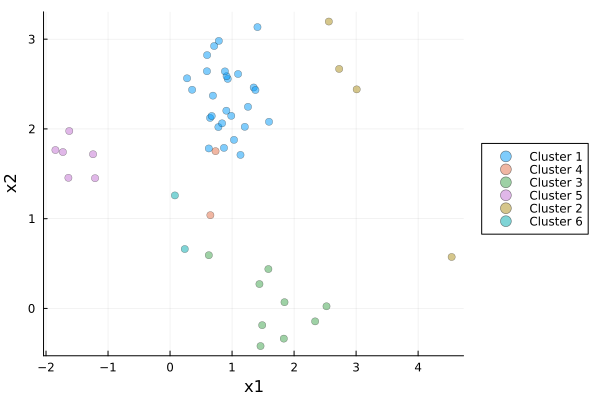

In [30]:
v = unique(temp_z)
p = sortperm(v)
rank = similar(v)
rank[p] = 1:length(v)
rankmap = Dict(v[i] => rank[i] for i in eachindex(v))
replaced_z = [ get(rankmap, val, val) for val in temp_z ];
plot_clusters(percepts, replaced_z)

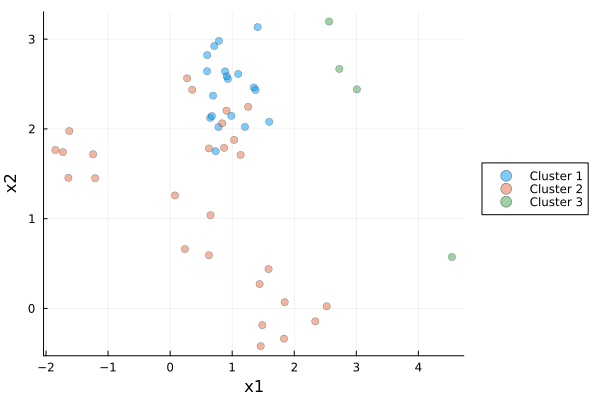

In [ ]:
clusters = [obj.z for obj in cat2_splits[50].train_objects_skewed for _ in obj.percepts]
plot_clusters(percepts, clusters)

In [38]:
# total number of training observations
function total_points(clusters::Vector{TraditionalHDPClusterStats})
    s = 0
    for cs in clusters
        s += cs.n
    end
    return s
end

total_points (generic function with 2 methods)

In [39]:
"""
    log_post_pred_x(x_new, clusters, hyper)

Implements Eq (9): log P(x_new | x) for the traditional HDP+,infinity
given:
- x_new   : new observation (Vector{Float64})
- clusters : Vector{TraditionalHDPClusterStats} for *training* data
- hyper    : TraditionalHDPHyperparams
"""
function log_post_pred_x(x_new::Vector{Float64},
                         clusters::Vector{TraditionalHDPClusterStats},
                         hyper::TraditionalHDPHyperparams)

    K = length(clusters)
    I = total_points(clusters)   # total training points
    alpha = hyper.alpha

    # Sanity: nothing to predict from if I == 0
    if I == 0
        # pure prior predictive
        return log_predictive_new(x_new, hyper)
    end

    log_terms = Vector{Float64}(undef, K + 1)
    @inbounds fill!(log_terms, -Inf) # fill all log_terms with -Inf (log 0), assumes 0 prob

    # existing clusters
    for k in 1:K
        nk = clusters[k].n
        if nk == 0
            continue # Skip empty clusters
        end
        prior_weight = nk / (I + alpha)                      
        log_lik = log_predictive_existing(x_new, clusters[k], hyper) # P(x_new | cluster k)
        log_terms[k] = log(prior_weight) + log_lik
    end

    # new cluster term
    prior_new = alpha / (I + alpha)
    log_lik_new = log_predictive_new(x_new, hyper)       # P(x_new | new cluster)
    log_terms[K+1] = log(prior_new) + log_lik_new

    # log-sum-exp to get log P(x_new | x)
    return logsumexp(log_terms)
end


log_post_pred_x

In [65]:
hyper = TraditionalHDPHyperparams(
    m0 = [0.0, 0.0], 
    k_clu = 1.0, 
    k_obj = 4.0,
    a0 = 1.0, 
    b0 = 1.0, 
    alpha = 1
)
n_splits = length(cat2_splits)
n_test_per_cat = 50
cat1_performance = Vector{Float64}(undef, n_splits)
cat2_performance = Vector{Float64}(undef, n_splits)

for i in 1:n_splits
    cat1_correct = cat2_correct = 0
    cat1_train = vcat((obj.percepts for obj in cat1_splits[i].train_objects_uniform)...)
    cat2_train = vcat((obj.percepts for obj in cat2_splits[i].train_objects_uniform)...)

    cat1_z, cat1_clu = trad_hdp_cluster_update(cat1_train, hyper; iters=1000)
    cat2_z, cat2_clu = trad_hdp_cluster_update(cat2_train, hyper; iters=1000)

    cat1_test = vcat((obj.percepts for obj in cat1_splits[i].test_objects)...)
    for j in 1:length(cat1_test)
        logp_test_given_cat1 = log_post_pred_x(cat1_test[j], cat1_clu, hyper)
        logp_test_given_cat2 = log_post_pred_x(cat1_test[j], cat2_clu, hyper)
        cat1_correct += logp_test_given_cat1 > logp_test_given_cat2
    end
    cat1_performance[i] = cat1_correct 

    cat2_test = vcat((obj.percepts for obj in cat2_splits[i].test_objects)...)
    for j in 1:length(cat2_test)
        logp_test_given_cat1 = log_post_pred_x(cat2_test[j], cat1_clu, hyper)
        logp_test_given_cat2 = log_post_pred_x(cat2_test[j], cat2_clu, hyper)
        cat2_correct += logp_test_given_cat1 < logp_test_given_cat2
    end 
    cat2_performance[i] = cat2_correct 
end 

println(cat1_performance ./ n_test_per_cat)
println(cat2_performance ./ n_test_per_cat)

[0.92, 0.92, 0.98, 0.92, 0.92, 0.86, 0.9, 0.96, 0.6, 0.92, 0.8, 0.88, 0.9, 1.0, 0.96, 0.8, 0.92, 0.66, 0.94, 0.96, 0.92, 0.94, 0.88, 0.88, 0.92, 0.8, 0.96, 1.0, 0.96, 0.84, 0.88, 0.96, 0.96, 0.98, 0.86, 0.92, 0.88, 0.94, 0.7, 0.88, 0.88, 0.92, 0.88, 0.88, 0.82, 0.78, 0.66, 0.82, 0.8, 0.98, 0.88, 0.84, 0.92, 0.96, 0.92, 0.98, 1.0, 0.94, 1.0, 0.96]
[0.88, 0.88, 0.96, 1.0, 0.92, 0.98, 0.9, 0.98, 1.0, 0.86, 0.9, 1.0, 0.88, 0.96, 0.92, 0.9, 1.0, 0.98, 0.88, 0.9, 0.96, 0.9, 0.94, 0.92, 0.88, 0.9, 0.92, 0.88, 0.6, 0.88, 0.9, 0.88, 1.0, 0.96, 0.86, 0.84, 0.88, 0.9, 0.9, 0.98, 0.88, 0.88, 1.0, 0.88, 0.9, 0.9, 0.98, 0.86, 0.92, 0.94, 0.94, 0.88, 0.98, 0.98, 0.92, 0.94, 0.94, 0.88, 0.94, 0.98]


In [70]:
mean(cat1_performance ./ n_test_per_cat), mean(cat2_performance ./ n_test_per_cat)

(0.8933333333333333, 0.9179999999999998)

In [68]:
sum(cat1_performance .> cat2_performance)

24